In [1]:
%load_ext autoreload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter("ignore")

from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
pd.set_option('display.precision', 3)
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Extra imports
from numpy.random import  uniform,normal
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from numpy.random import multivariate_normal
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
from time import time
from datetime import timedelta

In [3]:
learn_data = pd.read_csv("log_ILDS_train_X.csv", sep = ",", decimal = ".")
test_data = pd.read_csv("log_ILDS_test_X.csv", sep = ",", decimal = ".")

We are working on the competition dataset, but with preprocessing done. About the data:
- Resampling has been done on the learning data in order to achieve balance of classes.
- Transformations and scaling has been done beforehand.

# Clustering over all train data (no categorical data)

We wish to evaluate how our learning data is separated when we use no categorical data. To better visualize the dataset, we are going to apply PCA first.

In [4]:
num_data = learn_data.drop(columns = ["Female", "Target"])

corr = num_data.corr()
corr.style.background_gradient(cmap='RdBu')

,Age,TP,ALB,AR,DBratio,logTB,logDB,logAlkphos,logSgpt,logSgot
Age,1.000000,-0.216396,-0.263426,-0.174659,-0.123865,0.123027,0.132866,0.088969,-0.016649,0.012891
TP,-0.216396,1.000000,0.825708,0.341899,0.031839,-0.068446,-0.061913,-0.030246,-0.013462,-0.073995
ALB,-0.263426,0.825708,1.000000,0.775963,0.142935,-0.257085,-0.245076,-0.192406,-0.046159,-0.186751
AR,-0.174659,0.341899,0.775963,1.000000,0.170173,-0.311687,-0.297553,-0.330897,-0.098897,-0.207336
DBratio,-0.123865,0.031839,0.142935,0.170173,1.000000,-0.641503,-0.785244,-0.247257,-0.206700,-0.329012
logTB,0.123027,-0.068446,-0.257085,-0.311687,-0.641503,1.000000,0.976821,0.401648,0.414005,0.528434
logDB,0.132866,-0.061913,-0.245076,-0.297553,-0.785244,0.976821,1.000000,0.389482,0.386253,0.514675
logAlkphos,0.088969,-0.030246,-0.192406,-0.330897,-0.247257,0.401648,0.389482,1.000000,0.396281,0.360593
logSgpt,-0.016649,-0.013462,-0.046159,-0.098897,-0.206700,0.414005,0.386253,0.396281,1.000000,0.766843
logSgot,0.012891,-0.073995,-0.186751,-0.207336,-0.329012,0.528434,0.514675,0.360593,0.766843,1.000000


In [5]:
eigs, U = np.linalg.eig(corr) 
X_pca = num_data @ U

print(eigs)
print(X_pca.shape)

[3.88495993e+00 2.12473200e+00 1.21497115e+00 8.73016309e-01
 8.08165811e-01 5.18451086e-01 3.43291610e-01 2.09562966e-01
 2.10825601e-02 1.76657192e-03]
(620, 10)


<Figure size 600x400 with 0 Axes>

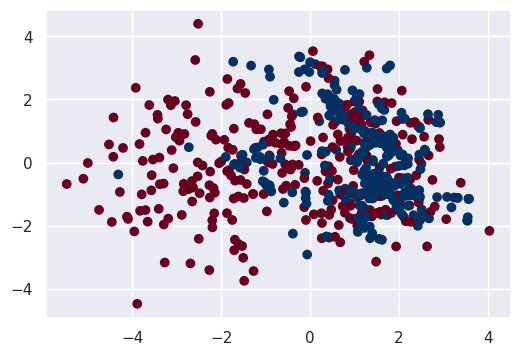

In [6]:
x = X_pca.loc[:, 0]
y = X_pca.loc[:, 1]

plt.figure(figsize = (6, 4))
_ = plt.scatter(x = x, y = y, c = learn_data['Target'], cmap = "RdBu")

In [16]:
index = pd.MultiIndex.from_arrays([['kmeans'], [2]], names=('model', 'K'))

results_df = pd.DataFrame(index=index, columns= ['CH score', 'Silhouette score', 'DB score'])

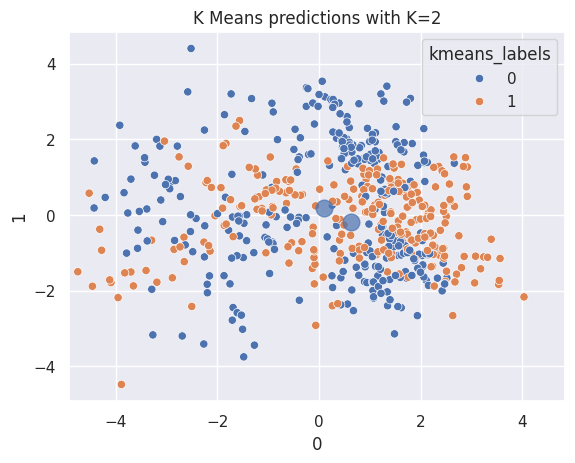

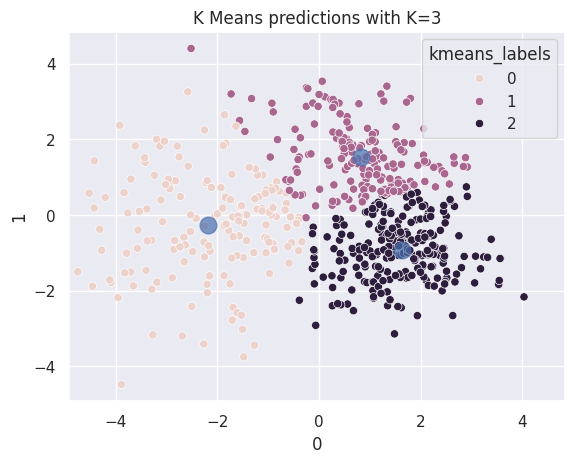

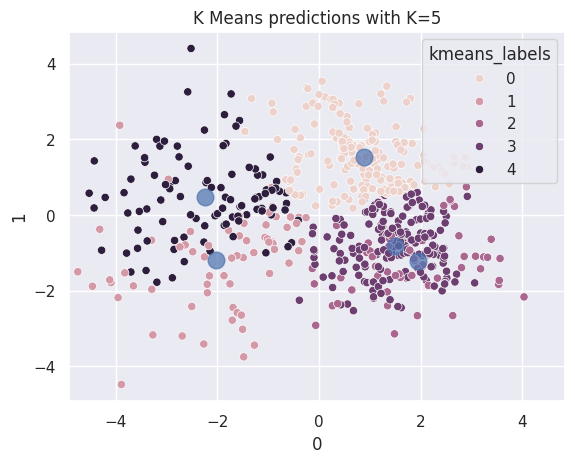

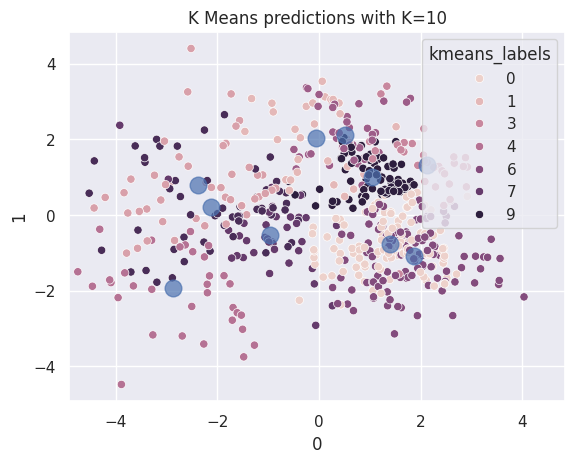

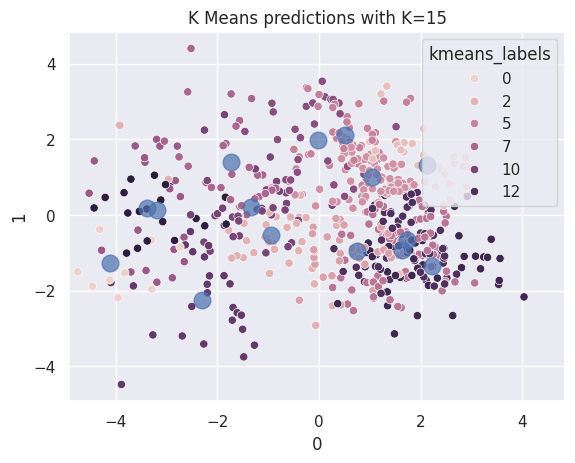

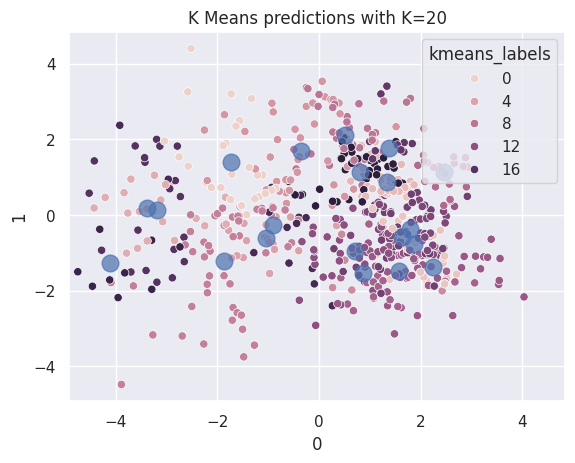

In [19]:
def compute_clustering_and_plot(K, data, results):

    # Train the model with k-means with given K
    kmeans = KMeans(n_clusters = K, max_iter=100)
    kmeans.fit(data)
    data['kmeans_labels'] = kmeans.labels_

    # Plot results
    sns.scatterplot(x = "0", y = "1", hue='kmeans_labels', data = data)
    plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:, 1], 'bo', markersize=12, alpha=0.7)
    plt.xlim(plt.ylim())
    plt.title(f'K Means predictions with K={K}')
    plt.show()

    # Compute metrics
    CH = calinski_harabasz_score(data, kmeans.labels_ )
    S = silhouette_score(data, kmeans.labels_ )
    DB = davies_bouldin_score(data, kmeans.labels_ )
    
    # store metrics
    results.loc[('kmeans', k),:] = [CH,S,DB]
    return results

X_pca.columns = X_pca.columns.astype(str)
K_values = [2, 3, 5, 10, 15, 20]
for k in K_values:
    results = compute_clustering_and_plot(k, X_pca, results_df)

In [20]:
results

CH score Silhouette score DB score
model  K                                    
kmeans 2    32.821            0.063    4.062
       3   243.396            0.252    1.401
       5   213.669            0.285    1.416
       10  269.142             0.36     1.15
       15  296.841            0.329    1.178
       20  370.586            0.352    1.093

The best clustering is given when using 20 clusters!!!

We will consider the use of 20 clusters, then. To evaluate whether we can find distinctions between sick and healthy patients in these clusters, let's make a probability table.

In [29]:
probtable = pd.DataFrame(columns = ["0", "1"])

K = 20
for i in range(K):
    total = sum(X_pca.kmeans_labels == i)
    prob0 = sum(learn_data["Target"][X_pca.kmeans_labels == i] == 0) / total
    prob1 = sum(learn_data["Target"][X_pca.kmeans_labels == i] == 1) / total
    probtable.loc[i,:] = [prob0, prob1]

probtable

,0,1
0,0.704,0.296
1,0.343,0.657
2,0.343,0.657
3,1.0,0.0
4,0.571,0.429
5,0.814,0.186
6,0.6,0.4
7,0.755,0.245
8,0.159,0.841
9,0.423,0.577


In [ ]:
for i in 